In [1]:
import os
import os.path
import sys
import math

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import keras
from keras import layers

Using TensorFlow backend.


In [4]:
sys.path.append(os.path.abspath('../dependencies/BristolStockExchange'))
sys.path.append(os.path.abspath('..'))

# System setup

Model characteristics:
* Continuous inputs, discrete actions
* Discrete events in continuous time

### Flappy Bird

* State: (hight, lower border of the hole, upper border of the hole, time to hole)
* Actions: {fly up, keep falling}
* Reward: time survived

In [5]:
class Game(object):
    def __init__(self):
        self.maxheight = 100
        self.mean_hole_height = 0.1 * self.maxheight
        self.min_time_to_hole = 20
        self.fall_rate = 5
        self.climb_rate = 3
        self.mean_time_to_hole = 2 * self.min_time_to_hole
        self.alive = True
        self.height = np.random.rand() * self.maxheight
        self._next_hole()
    
    def _next_hole(self):
        self.time_to_hole = self.min_time_to_hole + \
            (self.mean_time_to_hole - self.min_time_to_hole) * np.random.exponential()
        hole_height = self.mean_hole_height * np.random.exponential()
        hole_height /= (1 + hole_height / self.maxheight)
        self.hole_bottom = np.random.rand() * (self.maxheight - hole_height)
        self.hole_top = self.hole_bottom + hole_height
    
    def get_state(self):
        return np.array([self.height, self.hole_bottom, self.hole_top, self.time_to_hole])
    
    def time_step(self, action):
        if not self.alive:
            return 0
        dt = np.random.exponential()
        if dt > self.time_to_hole:
            dt = self.time_to_hole
        assert action == 1 or action == 0
        if action == 1:
            self.height += self.climb_rate * dt
        else:
            self.height -= self.fall_rate * dt
        self.time_to_hole -= dt
        if self.time_to_hole <= 0:
            if self.height < self.hole_bottom or self.height > self.hole_top:
                self.alive = False
            else:
                self._next_hole()
        return dt

In [9]:
# Play the game
game = Game()
while True:
    print(game.get_state())
    action = int(input())
    game.time_step(action)
    if not game.alive:
        print("DEAD!")
        break

[ 33.28533237   1.37246065   3.92825484  23.66874501]
0
[ 26.28422534   1.37246065   3.92825484  22.2685236 ]
0
[ 24.6594706    1.37246065   3.92825484  21.94357265]
0
[ 16.50206843   1.37246065   3.92825484  20.31209222]
0
[ 13.86105878   1.37246065   3.92825484  19.78389029]
0
[ 13.44244887   1.37246065   3.92825484  19.70016831]
0
[ 13.19709416   1.37246065   3.92825484  19.65109736]
0
[-14.10443304   1.37246065   3.92825484  14.19079193]
1
[ -7.5734632    1.37246065   3.92825484  12.01380198]
1
[ -5.79847381   1.37246065   3.92825484  11.42213885]
1
[ 0.5641037   1.37246065  3.92825484  9.30127968]
1
[ 2.38805699  1.37246065  3.92825484  8.69329525]
1
[ 4.48328057  1.37246065  3.92825484  7.99488739]
1
[ 4.66011379  1.37246065  3.92825484  7.93594298]
0
[-0.53016573  1.37246065  3.92825484  6.89788708]
1
[ 0.63622974  1.37246065  3.92825484  6.50908859]
1
[ 6.5203922   1.37246065  3.92825484  4.5477011 ]
0
[-0.80050373  1.37246065  3.92825484  3.08352191]
1
[ 1.27044627  1.37246065

In [47]:
def make_model(inputs, outputs):
    input_layer = keras.layers.Input(shape=(inputs,))
    layer1 = keras.layers.Dense(inputs + outputs, activation='tanh')
    layer2 = keras.layers.Dense(outputs, activation='tanh')
    scale_layer = keras.layers.Dense(outputs, activation='linear')
    model = keras.Model(inputs=input_layer, outputs=scale_layer(layer2(layer1(input_layer))))
    #model.compile('sgd', loss='mean_squared_error')
    model.compile('RMSProp', loss='mean_squared_error')
    return model

class Learner(object):
    def __init__(self, state_scale, reward_scale, num_actions):
        self.move_score_model = make_model(len(state_scale) + num_actions, 1)
        self.state_scale = state_scale
        self.reward_scale = reward_scale
        self.action_vec = np.eye(num_actions)
        self.last_move_learn_boost = 10
        self.self_trust = 0.0
        self.trust_rate = 1e-5
        
    def _move_and_score(self, state):
        best = None
        best_score = None
        for act, actvec in enumerate(self.action_vec):
            score = self.move_score_model.predict(np.concatenate([state / self.state_scale, actvec])[np.newaxis, :])[0, 0]
            if not np.isfinite(score):
                raise AssertionError("predict({}, {}) = {}".format(state, actvec, score))
            if best_score is None or score > best_score:
                best_score = score
                best = act
        return best, best_score
    
    def learn(self, state, action, reward, next_state, value_proxy):
        #print("learn({}, {}, {}, {}, {})".format(state, action, reward, next_state, value_proxy))
        if not np.all(np.isfinite(state)) or not np.isfinite(reward) or not np.all(np.isfinite(next_state)):
            raise ValueError("NaNs in input: {}, {}, {}, {}".format(state, action, reward, next_state))
        next_move, next_score = self._move_and_score(next_state)
        from_next = reward / self.reward_scale + next_score
        prediction = self.move_score_model.predict(np.concatenate([state / self.state_scale, self.action_vec[action]])[np.newaxis, :])[0, 0]
        to_learn = self.self_trust * from_next + (1 - self.self_trust) * (reward + value_proxy) / self.reward_scale
        #print("old prediction: {}, score from next: {}, reward to learn: {}".\
        #      format(prediction, from_next, to_learn))
        self.move_score_model.train_on_batch(np.concatenate([state / self.state_scale, self.action_vec[action]])[np.newaxis, :],
                                             np.array([[to_learn]]))
        self.self_trust += self.trust_rate * (1 - self.self_trust)
    
    def learn_last(self, state, action, reward):
        for i in range(self.last_move_learn_boost):
            self.move_score_model.train_on_batch(np.concatenate([state / self.state_scale, self.action_vec[action]])[np.newaxis, :],
                                                 np.array([[reward / self.reward_scale]]))
    
    def move(self, state):
        move, score = self._move_and_score(state)
        return move

In [48]:
# Play the game
def train_play(learner):
    game = Game()
    history = []
    total_reward = 0.0
    while True:
        state = game.get_state()
        #print(state)
        action = learner.move(state)
        #print(action)
        reward = game.time_step(action)
        history.append((state, action, reward))
        total_reward += reward
        if not game.alive:
            #print("DEAD! Survived for {}".format(total_reward))
            learner.learn_last(state, action, reward)
            return history, total_reward
        learner.learn(state, action, reward, game.get_state(), game.get_state()[3])

In [49]:
game = Game()
learner = Learner(np.array([game.maxheight, game.maxheight, game.maxheight, game.mean_time_to_hole]),
                  game.mean_time_to_hole, 2)

In [50]:
train_play(learner)[1]

36.91217246743511

In [51]:
history = []

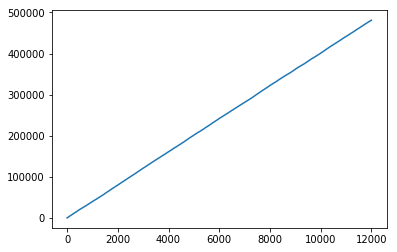

In [62]:
for i in range(10000):
    history.append(train_play(learner)[1])
plt.plot(np.cumsum(history))

In [53]:
learner.move_score_model.predict(np.array([10, 24, 43, 20, 1, 0])[np.newaxis, :]) * learner.reward_scale

array([[37.831364]], dtype=float32)

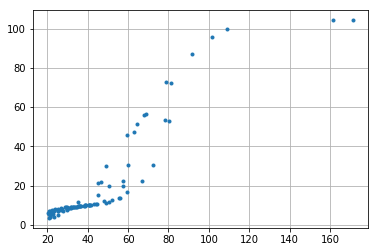

In [64]:
foo = np.zeros((100, 6))
foo[:, 4] = 1
for i in range(foo.shape[0]):
    foo[i, :4] = Game().get_state()
fooy = learner.move_score_model.predict(foo / np.concatenate([learner.state_scale, np.ones(2)])).reshape(-1) * learner.reward_scale
plt.plot(foo[:, 3], fooy, '.')
plt.grid()

In [173]:
learner.move_score_model.get_weights()

[array([[ 0.56055343, -0.2953229 , -0.57221574,  0.00282226, -0.35351723,
          0.04219814,  0.241941  ],
        [ 0.46892512,  0.05646466, -0.3568987 ,  0.01987873,  0.01609045,
          0.02460651,  0.37089428],
        [-0.10343911, -0.12443767,  0.31104186,  0.60404915, -0.11452886,
         -0.0784584 , -0.41399062],
        [ 0.09086863,  0.89367056, -0.6254406 , -0.652426  , -0.03195759,
         -0.33034462,  0.2409304 ],
        [-0.9263537 , -0.54608697,  0.9270808 ,  0.14529435,  0.29492468,
         -0.21144457, -0.7584317 ],
        [ 0.7691986 , -0.3643534 ,  0.36017317, -0.28996354, -0.2515313 ,
          0.42179015,  0.3386293 ]], dtype=float32),
 array([ 0.03142659,  0.01304426,  0.22870097,  0.46240875,  0.03956511,
         0.01948222, -0.14937036], dtype=float32),
 array([[-0.5176777 ],
        [-0.54054147],
        [ 0.29364556],
        [ 0.09942868],
        [-0.65357757],
        [ 1.4822562 ],
        [-0.6581498 ]], dtype=float32),
 array([0.11680523], 

#### Test the ability of the neural network to learn...

In [34]:
model = make_model(6, 1)

In [41]:
data = np.random.rand(6000).reshape((1000, 6)) * 3

In [42]:
for row in data:
    model.train_on_batch(row[np.newaxis, :], row[[-1]])

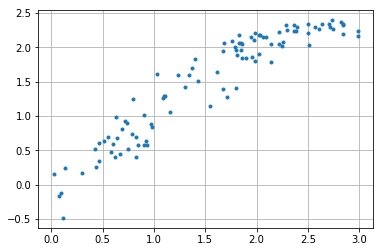

In [43]:
foo = np.random.rand(600).reshape((100, 6)) * 3
fooy = model.predict(foo)
plt.plot(foo[:, -1], fooy.reshape(-1), '.')
plt.grid(True)